In [640]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir 'logs/'
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import KBinsDiscretizer
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers
from sklearn.preprocessing import PolynomialFeatures

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17008), started 1 day, 4:08:48 ago. (Use '!kill 17008' to kill it.)

In [641]:
df = pd.read_csv('diabetes.csv')

In [642]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [643]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


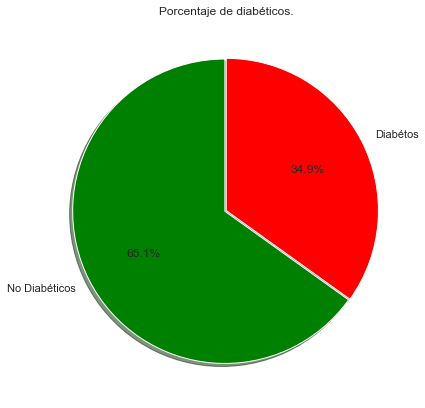

In [644]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [645]:
df2 = df.copy()
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

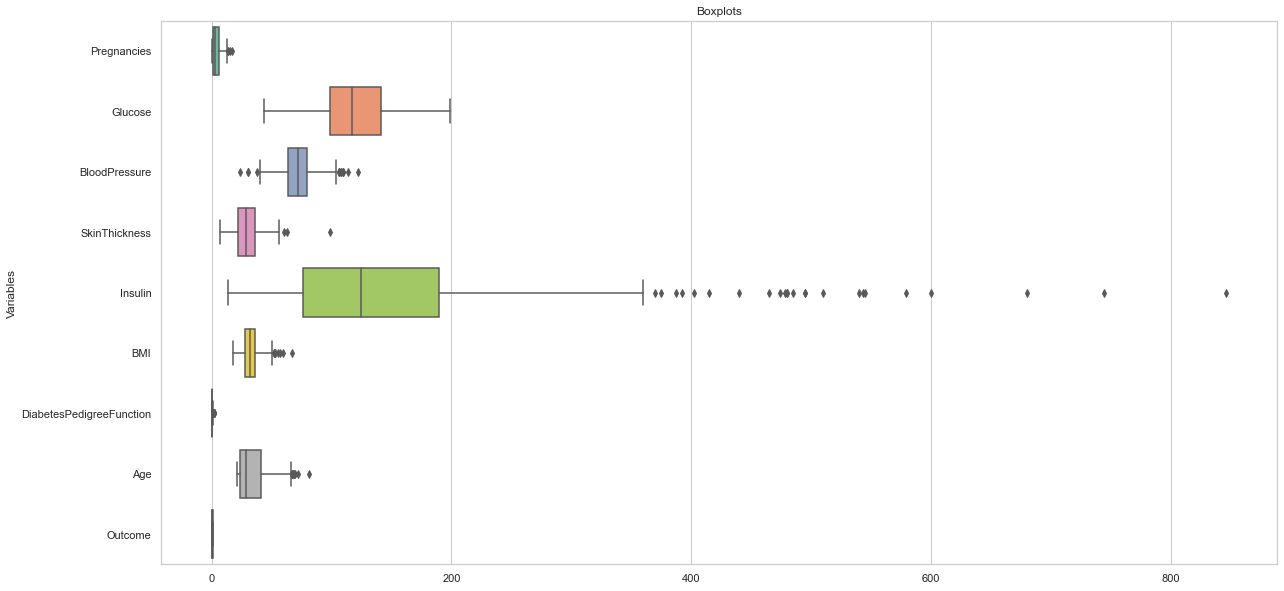

In [646]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots")
ax = sns.boxplot(data = df2, 
  orient = 'h', 
  palette = 'Set2')

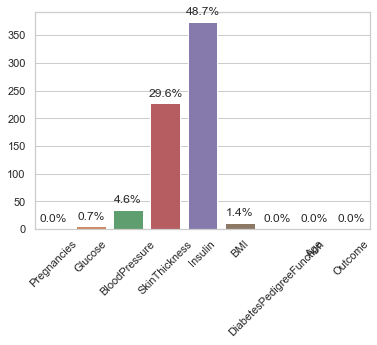

In [647]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df2.columns, y=df2.isnull().sum())
plt.xticks(rotation=45);
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/df.shape[0], '.1f') + "%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

In [648]:
correlations = df2.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

In [649]:
df = df.drop(['Insulin'], axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1


In [650]:
msk = np.random.rand(len(df)) < 0.9
train_val_df = df[msk]
testData = df[~msk]

mskVal = np.random.rand(len(train_val_df)) < 0.9
trainData = train_val_df[mskVal]
validationData = train_val_df[~mskVal]


In [651]:
 def separate_data_and_labels(df):
        data = df.copy()
        y_values = data[data.columns[-1]].values.reshape(data.shape[0], 1)
        data = data.drop([data.columns[-1]], axis=1)
        return data, y_values

In [652]:
x_train_data, y_train_values = separate_data_and_labels(trainData)
x_val_data, y_val_values = separate_data_and_labels(validationData)
x_test_data, y_test_values = separate_data_and_labels(testData)

In [653]:
del(testData)
del(validationData)
del(trainData)
del(df)

In [654]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [655]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [656]:
class DiabetesPredictor:
    def __init__(self, name):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.

    """
        self.name = name

    def fit(self, train_df, y_train, val_df, y_val, replaceOutliers=False, deleteRowsWithOutliers=False, replaceNulls=False,deleteRowsWithNulls=False, nullColumns=[], outliersColumnsMap={}, columnsToRemove=[], polyFeatDeg = -1, binsDiscretizer = -1):
        train_dataframe = train_df.copy()
        fit_df = train_dataframe.copy()

        self.columnsToRemove = columnsToRemove.copy()
        self.nullCols = nullColumns.copy()
        self.replaceNulls = replaceNulls
        self.replaceOutliers = replaceOutliers
        self.deleteRowsWithNulls = deleteRowsWithNulls
        self.deleteRowsWithOutliers = deleteRowsWithOutliers
        self.polyFeatDeg = polyFeatDeg
        self.binsDiscretizer = binsDiscretizer

        self.replace_values_nulls = []
        self.replace_values_outliers = []
        self.outliersLimits = []

        self.nullCols = [n for n in self.nullCols if n not in self.columnsToRemove]
        self.outlierCols = {}
        for k in outliersColumnsMap:
            if k not in self.columnsToRemove:
                self.outlierCols[k] = outliersColumnsMap[k].copy()

        if (self.replaceNulls or self.deleteRowsWithNulls):
            fit_df[self.nullCols] = fit_df[self.nullCols].replace(0,np.NaN)
        ##Parametros##
        self.replace_values_outliers = self.__get_cols_median__(fit_df)
        self.outliersLimits = self.__get_outliers_limits__(fit_df)

        fit_df = self.__deal_with_outliers__(fit_df)

        ##Parametros##
        self.replace_values_nulls = self.__get_cols_median__(fit_df)

        
        fit_df = self.__deal_with_nulls__(fit_df)
        
        if (self.polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=self.polyFeatDeg)
            fit_df = poly.fit_transform(fit_df)

        if (self.binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=self.binsDiscretizer, encode='ordinal', strategy='uniform')
            fit_df = disc.fit_transform(fit_df)

        ##Parametros##
        self.mean_cols = self.__get_cols_mean__(fit_df)
        self.std_cols = self.__get_cols_std__(fit_df)

        train_dataframe = self.__preprocess_data__(train_dataframe)
        x_train_values = train_dataframe.values
        y_train_values = y_train.copy()

        self.input_shape = x_train_values.shape

        x_val_df = val_df.copy()
        x_val_df = self.__preprocess_data__(x_val_df)
        x_val_values = x_val_df.values
        y_val_values = y_val.copy()

        self.hypermodel = self.__tune_hyperparams__(x_train_values, y_train_values, x_val_values,y_val_values)

        return self.evaluate(x_val_df, y_val_values, testing = False)
        
    def __preprocess_data__(self, data):
        df = data.copy()
        df = self.__remove_columns__(df)

        if (self.replaceNulls or self.deleteRowsWithNulls):
            df[self.nullCols] = df[self.nullCols].replace(0,np.NaN)

        df = self.__deal_with_outliers__(df)
        df = self.__deal_with_nulls__(df)
        
        if (self.polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=self.polyFeatDeg)
            df = poly.fit_transform(df)

        if (self.binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=self.binsDiscretizer, encode='ordinal', strategy='uniform')
            df = disc.fit_transform(df)

        df = self.__normalize_data__(df)

        return df

    def __get_cols_mean__(self, data):
        x = data.values
        means = np.mean(x, axis=0, keepdims=True)
        df = pd.DataFrame(means, columns = data.columns)
        return df

    def __get_cols_std__(self, data):
        x = data.values
        stds = np.std(x, axis=0, keepdims=True)
        df = pd.DataFrame(stds, columns = data.columns)
        return df

    def __get_cols_median__(self, data):
        x = data.values
        medians = np.median(x, axis=0, keepdims=True)
        df = pd.DataFrame(medians, columns = data.columns)
        return df

    def __get_outliers_limits__(self, data):
        df = pd.DataFrame(np.zeros((1,len(data.columns))), columns=data.columns)
        df = df.astype('object')
        for col in data.columns:
            col_min = 0
            col_max = np.Infinity
            if (col in self.outlierCols):
                #Cálculo de parámetros para obtener los outliers.
                q1 = data[col].quantile(0.25)
                q3 = data[col].quantile(0.75)
                iqr = q3-q1
                #Límites de los valores tipicos.
                lower_tail = q1 - 1.5 * iqr
                upper_tail = q3 + 1.5 * iqr

                col_min = min(lower_tail, self.outlierCols[col][0])
                col_max = max(upper_tail,self.outlierCols[col][1])
            lims = [col_min, col_max]
            df[col][0] = lims
        return df


    def __deal_with_outliers__(self, data):
        df = data.copy()
        if(self.replaceOutliers):
            df = self.__replace_outliers__(df)
        elif(self.deleteRowsWithOutliers): 
            df =  self.__delete_row_with_outliers__(df)
        return df

    def __replace_outliers__(self, dataframe):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        df = dataframe.copy()
        for col in self.replace_values_outliers.columns:
            out_min = self.replace_values_outliers[col][0]
            out_max = self.replace_values_outliers[col][1]
            for i in df[col]:
                if i > out_max or i < out_min:
                    df[col] = df[col].replace(i, self.replace_values_outliers[col])
        return df

    def __delete_row_with_outliers__(self, dataframe):
        #Para cada columna (excepto para el Outcome) se buscan los outliers para borrar la fila
        df = dataframe.copy()
        for col in self.replace_values_outliers.columns:
            out_min = self.replace_values_outliers[col][0]
            out_max = self.replace_values_outliers[col][1]
            df = df[(out_min < df[col]) & (df[col] < out_max)]
        return df

    def __deal_with_nulls__(self, data):
        df = data.copy()
        if(self.replaceNulls):
            df = self.__replace_nulls__(df)
        elif (self.deleteRowsWithNulls):
            df = self.__delete_row_with_nulls__(df)
        return df

    def __replace_nulls__(self, dataframe):
        df = dataframe.copy()
        for col in self.nullCols:
            df[col]=df[col].replace(np.NaN, self.replace_values_nulls[col])
        return df

    def __delete_row_with_nulls__(self, dataframe):
        df = dataframe.copy()
        for col in self.nullCols:
            df = df[pd.notnull(df[col])]
        return df

    def __normalize_data__(self, dataframe):
        # Mean, columnar axis.
        df = dataframe.copy()
        for col in df.columns:
            if (self.std_cols[col][0] != 0):
                df[col] = (df[col] - self.mean_cols[col][0]) / self.std_cols[col][0]
            else:
                df[col] = 0
        return df

    def __remove_columns__(self, dataframe):
        df = dataframe.copy()
        df = df.drop(self.columnsToRemove, axis=1)
        return df

    def __model_builder__(self,hp):
        model = Sequential()
        initializer = tf.keras.initializers.GlorotNormal(seed=7)
        model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', input_shape=(self.input_shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate = hp.Float('learning_rate', 1e-5, 1.0, sampling='log', default=1e-3)
        

        model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def __tune_hyperparams__(self, x_train, y_train, x_val, y_val):
        # log_dir = "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")
        # hist_callback = tf.keras.callbacks.TensorBoard(
        #     log_dir=log_dir,
        #     histogram_freq=1,
        #     embeddings_freq=1,
        #     write_graph=True,
        #     update_freq='batch')
        tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=20,
                     factor=3,
                     executions_per_trial=1,
                     project_name=self.name,
                     directory='saved_models'
                     )
        tuner.search(x_train, y_train, epochs=100, validation_data = (x_val, y_val), use_multiprocessing=True)
        best_hps = tuner.get_best_hyperparameters(num_trials=2)[0]
        model = tuner.hypermodel.build(best_hps)
        history = model.fit(x_train, y_train, epochs=100, validation_data = (x_val, y_val), verbose=0)
        plot_loss(history)
        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        hypermodel = tuner.hypermodel.build(best_hps)
        hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_data = (x_val, y_val))
        return hypermodel

    def evaluate(self, x_val_df, y_val, testing=True):
        x_df = x_val_df.copy()
        predictions, rounded_preds = self.predict(x_df, testing=testing)

        fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_val, predictions)
        auc_keras = auc(fpr_keras, tpr_keras)
        spe = specificity(y_val.astype(float),  rounded_preds.astype(float))
        sen = sensitivity(y_val.astype(float),  rounded_preds.astype(float))
        ppv = positive_predictive_value(y_val.astype(float), rounded_preds.astype(float))
        npv = negative_predictive_value(y_val.astype(float), rounded_preds.astype(float))

        self.plot_roc(fpr_keras, tpr_keras, auc_keras)

        print('AUC ' + str(auc_keras))
        print('Specificity: ' + str(spe))
        print('Sensitivity: ' + str(sen))
        print('Positive Predictive Value: ' + str(ppv))
        print('Negative Predictive Value: ' + str(npv))

        return auc_keras, spe, sen, ppv, npv

    def predict(self, x_val_df, testing=True):
        x_df = x_val_df.copy()
        if (testing):
            x_df = self.__preprocess_data__(x_df)
        predictions = self.hypermodel(x_df.values)
        rounded_preds = np.rint(predictions)
        return predictions, rounded_preds

    def plot_roc(self, fpr_keras, tpr_keras, auc_keras):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr_keras, tpr_keras, label=' (Area = {:.3f})'.format(auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve ' + self.name)
        plt.legend(loc='best')
        plt.show()
        

In [657]:
predictor = DiabetesPredictor('predictor')

Trial 30 Complete [00h 00m 06s]
val_loss: 627.9743041992188

Best val_loss So Far: 0.7114841938018799
Total elapsed time: 00h 02m 18s
INFO:tensorflow:Oracle triggered exit


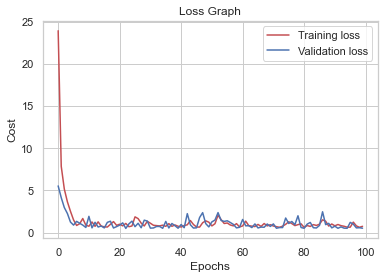

Epoch 1/23
20/20 [==============================] - 1s 20ms/step - loss: 26.0466 - auc: 0.4893 - val_loss: 5.8077 - val_auc: 0.7021
Epoch 2/23
20/20 [==============================] - 0s 3ms/step - loss: 7.7915 - auc: 0.6007 - val_loss: 4.0726 - val_auc: 0.6790
Epoch 3/23
20/20 [==============================] - 0s 3ms/step - loss: 5.4934 - auc: 0.6309 - val_loss: 3.2695 - val_auc: 0.6960
Epoch 4/23
20/20 [==============================] - 0s 3ms/step - loss: 3.9487 - auc: 0.6395 - val_loss: 4.3039 - val_auc: 0.6372
Epoch 5/23
20/20 [==============================] - 0s 3ms/step - loss: 3.1118 - auc: 0.5998 - val_loss: 1.3950 - val_auc: 0.7631
Epoch 6/23
20/20 [==============================] - 0s 3ms/step - loss: 2.5428 - auc: 0.5848 - val_loss: 1.2633 - val_auc: 0.7888
Epoch 7/23
20/20 [==============================] - 0s 7ms/step - loss: 1.4741 - auc: 0.5771 - val_loss: 1.0606 - val_auc: 0.6359
Epoch 8/23
20/20 [==============================] - 0s 4ms/step - loss: 1.1891 - auc: 0.

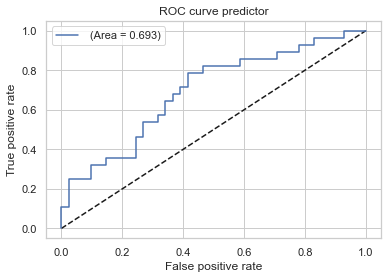

AUC 0.6933797909407665
Specificity: tf.Tensor(0.9756097537180249, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.21428571352040815, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.8571428448979593, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.6451612892819979, shape=(), dtype=float64)


In [658]:
 aucPred, spePred, senPred, ppvPred, npvPred = predictor.fit(x_train_data, y_train_values, x_val_data, y_val_values)

## Limpiando Datos
#### Reemplazando Nulls por la mediana

INFO:tensorflow:Reloading Oracle from existing project saved_models\rep_nulls_predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\rep_nulls_predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


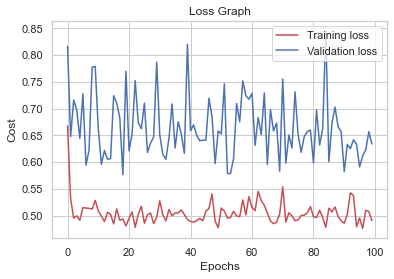

Best epoch: 19
Epoch 1/19
20/20 [==============================] - 2s 26ms/step - loss: 0.7801 - auc: 0.7525 - val_loss: 0.8915 - val_auc: 0.7111
Epoch 2/19
20/20 [==============================] - 0s 3ms/step - loss: 0.6206 - auc: 0.7748 - val_loss: 0.7610 - val_auc: 0.6866
Epoch 3/19
20/20 [==============================] - 0s 2ms/step - loss: 0.5152 - auc: 0.8235 - val_loss: 0.6454 - val_auc: 0.7024
Epoch 4/19
20/20 [==============================] - 0s 2ms/step - loss: 0.5064 - auc: 0.8138 - val_loss: 0.7463 - val_auc: 0.7156
Epoch 5/19
20/20 [==============================] - 0s 3ms/step - loss: 0.4995 - auc: 0.8249 - val_loss: 0.6466 - val_auc: 0.7251
Epoch 6/19
20/20 [==============================] - 0s 3ms/step - loss: 0.4923 - auc: 0.8373 - val_loss: 0.6751 - val_auc: 0.6839
Epoch 7/19
20/20 [==============================] - 0s 2ms/step - loss: 0.4968 - auc: 0.8261 - val_loss: 0.6809 - val_auc: 0.7092
Epoch 8/19
20/20 [==============================] - 0s 3ms/step - loss: 0.

In [29]:
predictorRepNulls = DiabetesPredictor('rep_nulls_predictor')
aucRepNulls, speRepNulls, senRepNulls, ppvRepNulls, npvRepNulls = predictor.fit(x_train_data, y_train_values, x_val_data, y_val_values,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])

#### Removiendo Nulls

INFO:tensorflow:Reloading Oracle from existing project saved_models\rem_nulls_predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\rem_nulls_predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


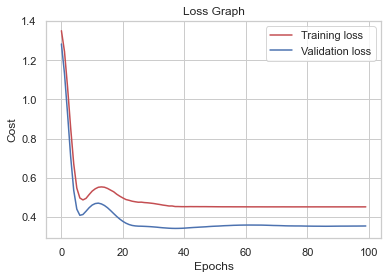

Best epoch: 38
Epoch 1/38
14/14 [==============================] - 1s 33ms/step - loss: 1.3505 - auc: 0.2931 - val_loss: 1.2861 - val_auc: 0.3725
Epoch 2/38
14/14 [==============================] - 0s 3ms/step - loss: 1.2495 - auc: 0.3081 - val_loss: 1.1333 - val_auc: 0.4010
Epoch 3/38
14/14 [==============================] - 0s 3ms/step - loss: 1.0680 - auc: 0.3502 - val_loss: 0.9259 - val_auc: 0.4765
Epoch 4/38
14/14 [==============================] - 0s 3ms/step - loss: 0.8609 - auc: 0.4500 - val_loss: 0.7078 - val_auc: 0.6078
Epoch 5/38
14/14 [==============================] - 0s 3ms/step - loss: 0.6690 - auc: 0.6397 - val_loss: 0.5366 - val_auc: 0.7902
Epoch 6/38
14/14 [==============================] - 0s 3ms/step - loss: 0.5508 - auc: 0.7870 - val_loss: 0.4407 - val_auc: 0.8990
Epoch 7/38
14/14 [==============================] - 0s 3ms/step - loss: 0.4942 - auc: 0.8359 - val_loss: 0.4084 - val_auc: 0.8990
Epoch 8/38
14/14 [==============================] - 0s 3ms/step - loss: 0.

In [32]:
predictorRemNulls = DiabetesPredictor('rem_nulls_predictor')
aucRemNulls, speRemNulls, senRemNulls, ppvRemNulls, npvRemNulls = predictor.fit(x_train_data, y_train_values, x_val_data, y_val_values,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])

#### Removiendo Outliers

INFO:tensorflow:Reloading Oracle from existing project saved_models\rem_outliers_predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\rem_outliers_predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


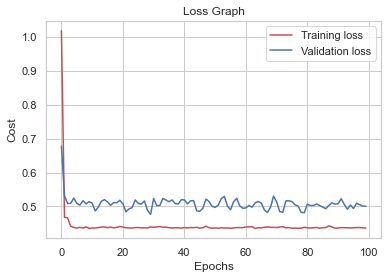

Best epoch: 30
Epoch 1/30
14/14 [==============================] - 1s 32ms/step - loss: 1.0269 - auc: 0.4102 - val_loss: 0.6583 - val_auc: 0.6714
Epoch 2/30
14/14 [==============================] - 0s 3ms/step - loss: 0.4659 - auc: 0.8491 - val_loss: 0.5551 - val_auc: 0.7833
Epoch 3/30
14/14 [==============================] - 0s 3ms/step - loss: 0.4561 - auc: 0.8551 - val_loss: 0.5214 - val_auc: 0.7984
Epoch 4/30
14/14 [==============================] - 0s 4ms/step - loss: 0.4408 - auc: 0.8595 - val_loss: 0.5182 - val_auc: 0.7954
Epoch 5/30
14/14 [==============================] - 0s 3ms/step - loss: 0.4402 - auc: 0.8593 - val_loss: 0.5151 - val_auc: 0.7944
Epoch 6/30
14/14 [==============================] - 0s 3ms/step - loss: 0.4368 - auc: 0.8594 - val_loss: 0.5064 - val_auc: 0.7984
Epoch 7/30
14/14 [==============================] - 0s 3ms/step - loss: 0.4383 - auc: 0.8594 - val_loss: 0.5180 - val_auc: 0.7903
Epoch 8/30
14/14 [==============================] - 0s 3ms/step - loss: 0.

In [34]:
predictorRemOutliers = DiabetesPredictor('rem_outliers_predictor') ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])

aucRemOut, speRemOut, senRemOut, ppvRemOut, npvRemOut = predictor.fit(x_train_data, y_train_values, x_val_data, y_val_values,,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], deleteRowsWithOutliers=True, outliersColumns={'BMI': [18.5, 50],'BloodPressure':[40,120],'SkinThickness': [0, np.Infinity], 'Pregnancies': [0, np.Infinity]])

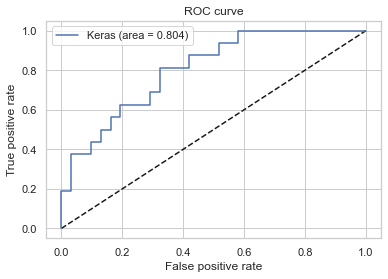

AUC 0.8044354838709677
Specificity: tf.Tensor(0.8709677391259105, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.437499997265625, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6363636305785125, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.7499999979166666, shape=(), dtype=float64)


In [35]:
predictorRemOutliers.plot_roc()
predictorRemOutliers.get_metrics()

#### Reemplazando Outliers


INFO:tensorflow:Reloading Oracle from existing project saved_models\rep_outliers_predictor\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\rep_outliers_predictor\tuner0.json
INFO:tensorflow:Oracle triggered exit


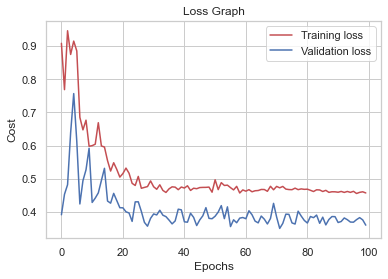

Best epoch: 72
Epoch 1/72
14/14 [==============================] - 1s 37ms/step - loss: 0.9110 - auc: 0.5144 - val_loss: 0.3891 - val_auc: 0.9293
Epoch 2/72
14/14 [==============================] - 0s 4ms/step - loss: 0.7075 - auc: 0.8130 - val_loss: 0.4375 - val_auc: 0.9222
Epoch 3/72
14/14 [==============================] - 0s 3ms/step - loss: 0.9107 - auc: 0.8141 - val_loss: 0.4735 - val_auc: 0.9051
Epoch 4/72
14/14 [==============================] - 0s 3ms/step - loss: 0.8389 - auc: 0.8184 - val_loss: 0.5986 - val_auc: 0.8717
Epoch 5/72
14/14 [==============================] - 0s 3ms/step - loss: 0.8832 - auc: 0.8111 - val_loss: 0.7028 - val_auc: 0.8515
Epoch 6/72
14/14 [==============================] - 0s 4ms/step - loss: 0.8620 - auc: 0.8060 - val_loss: 0.5972 - val_auc: 0.8616
Epoch 7/72
14/14 [==============================] - 0s 4ms/step - loss: 0.6798 - auc: 0.8281 - val_loss: 0.4700 - val_auc: 0.8626
Epoch 8/72
14/14 [==============================] - 0s 4ms/step - loss: 0.

In [36]:
predictorRepOutliers = DiabetesPredictor(train_df,'rep_outliers_predictor' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120], ['Pregnancies',np.Infinity,0]])
predictorRepOutliers.train_model()
aucRepOut = predictorRepOutliers.validate_model()
print('AUC: ' + str(aucRepOut))

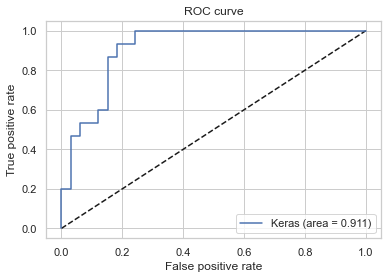

AUC 0.9111111111111111
Specificity: tf.Tensor(0.969696966758494, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.4666666635555556, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.8749999890625002, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.799999998, shape=(), dtype=float64)


In [37]:
predictorRepOutliers.plot_roc()
predictorRepOutliers.get_metrics()

#### Removiendo Columnas

BloodPressure
INFO:tensorflow:Reloading Oracle from existing project saved_models\BloodPressure\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\BloodPressure\tuner0.json
INFO:tensorflow:Oracle triggered exit


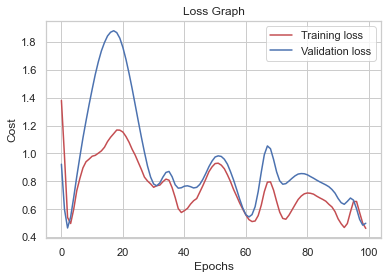

Best epoch: 3
Epoch 1/3
15/15 [==============================] - 1s 30ms/step - loss: 1.3839 - auc: 0.2727 - val_loss: 0.9249 - val_auc: 0.4837
Epoch 2/3
15/15 [==============================] - 0s 3ms/step - loss: 0.9615 - auc: 0.3713 - val_loss: 0.6057 - val_auc: 0.7300
Epoch 3/3
15/15 [==============================] - 0s 3ms/step - loss: 0.5564 - auc: 0.7608 - val_loss: 0.4647 - val_auc: 0.8831
Age
INFO:tensorflow:Reloading Oracle from existing project saved_models\Age\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\Age\tuner0.json
INFO:tensorflow:Oracle triggered exit


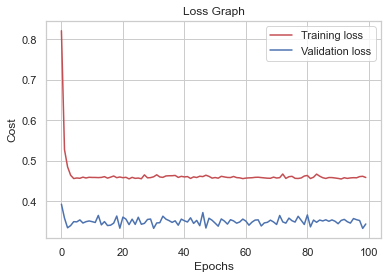

Best epoch: 99
Epoch 1/99
15/15 [==============================] - 1s 29ms/step - loss: 0.8528 - auc: 0.5499 - val_loss: 0.4087 - val_auc: 0.9025
Epoch 2/99
15/15 [==============================] - 0s 3ms/step - loss: 0.5139 - auc: 0.8299 - val_loss: 0.3601 - val_auc: 0.9084
Epoch 3/99
15/15 [==============================] - 0s 3ms/step - loss: 0.4855 - auc: 0.8386 - val_loss: 0.3348 - val_auc: 0.9059
Epoch 4/99
15/15 [==============================] - 0s 3ms/step - loss: 0.4646 - auc: 0.8451 - val_loss: 0.3626 - val_auc: 0.9076
Epoch 5/99
15/15 [==============================] - 0s 3ms/step - loss: 0.4603 - auc: 0.8442 - val_loss: 0.3520 - val_auc: 0.9109
Epoch 6/99
15/15 [==============================] - 0s 3ms/step - loss: 0.4595 - auc: 0.8424 - val_loss: 0.3481 - val_auc: 0.9134
Epoch 7/99
15/15 [==============================] - 0s 3ms/step - loss: 0.4618 - auc: 0.8394 - val_loss: 0.3626 - val_auc: 0.9151
Epoch 8/99
15/15 [==============================] - 0s 3ms/step - loss: 0.

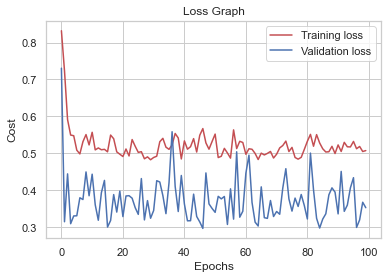

Best epoch: 47
Epoch 1/47
15/15 [==============================] - 1s 26ms/step - loss: 0.6751 - auc: 0.7355 - val_loss: 0.4430 - val_auc: 0.8857
Epoch 2/47
15/15 [==============================] - 0s 5ms/step - loss: 0.5376 - auc: 0.8102 - val_loss: 0.3576 - val_auc: 0.9277
Epoch 3/47
15/15 [==============================] - 0s 3ms/step - loss: 0.5081 - auc: 0.8008 - val_loss: 0.3219 - val_auc: 0.9252
Epoch 4/47
15/15 [==============================] - 0s 3ms/step - loss: 0.5141 - auc: 0.8194 - val_loss: 0.5501 - val_auc: 0.7681
Epoch 5/47
15/15 [==============================] - 0s 3ms/step - loss: 0.5136 - auc: 0.8031 - val_loss: 0.3818 - val_auc: 0.8975
Epoch 6/47
15/15 [==============================] - 0s 3ms/step - loss: 0.5007 - auc: 0.8078 - val_loss: 0.3430 - val_auc: 0.9412
Epoch 7/47
15/15 [==============================] - 0s 3ms/step - loss: 0.5188 - auc: 0.7980 - val_loss: 0.3612 - val_auc: 0.9000
Epoch 8/47
15/15 [==============================] - 0s 4ms/step - loss: 0.

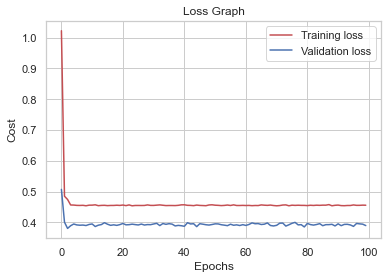

Best epoch: 3
Epoch 1/3
15/15 [==============================] - 2s 37ms/step - loss: 1.0190 - auc: 0.4202 - val_loss: 0.5173 - val_auc: 0.8205
Epoch 2/3
15/15 [==============================] - 0s 4ms/step - loss: 0.4857 - auc: 0.8323 - val_loss: 0.4011 - val_auc: 0.8787
Epoch 3/3
15/15 [==============================] - 0s 3ms/step - loss: 0.4727 - auc: 0.8452 - val_loss: 0.3797 - val_auc: 0.8826
SkinThickness
INFO:tensorflow:Reloading Oracle from existing project saved_models\SkinThickness\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\SkinThickness\tuner0.json
INFO:tensorflow:Oracle triggered exit


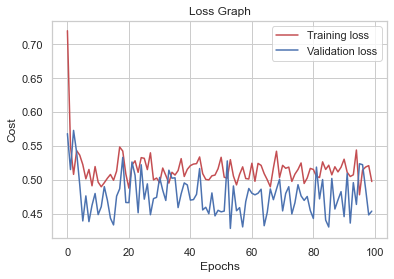

Best epoch: 54
Epoch 1/54
20/20 [==============================] - 2s 28ms/step - loss: 0.7583 - auc: 0.7509 - val_loss: 0.5457 - val_auc: 0.8465
Epoch 2/54
20/20 [==============================] - 0s 3ms/step - loss: 0.5825 - auc: 0.7860 - val_loss: 0.4629 - val_auc: 0.8251
Epoch 3/54
20/20 [==============================] - 0s 3ms/step - loss: 0.4975 - auc: 0.8185 - val_loss: 0.4211 - val_auc: 0.8548
Epoch 4/54
20/20 [==============================] - 0s 3ms/step - loss: 0.5227 - auc: 0.8026 - val_loss: 0.5085 - val_auc: 0.7922
Epoch 5/54
20/20 [==============================] - 0s 5ms/step - loss: 0.5278 - auc: 0.8005 - val_loss: 0.4436 - val_auc: 0.8502
Epoch 6/54
20/20 [==============================] - 0s 3ms/step - loss: 0.5229 - auc: 0.8059 - val_loss: 0.5151 - val_auc: 0.8098
Epoch 7/54
20/20 [==============================] - 0s 3ms/step - loss: 0.4922 - auc: 0.8187 - val_loss: 0.4972 - val_auc: 0.8080
Epoch 8/54
20/20 [==============================] - 0s 3ms/step - loss: 0.

In [38]:
bestAuc = aucRemOut
tryRemovingCols = ['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
removeCols = []
removeColsAuc = []
nullCols = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in tryRemovingCols:
	print(col)
	pred = DiabetesPredictor(df, col, deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=[col], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])
	pred.train_model()
	aucR = pred.validate_model()
	if (aucR>bestAuc):
		removeCols.append(col)
		removeColsAuc.append(aucR)



In [39]:
print(removeCols)
print(removeColsAuc)

['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
[0.8831360946745562, 0.907563025210084, 0.9260504201680673, 0.8816568047337279, 0.8079777365491652]


INFO:tensorflow:Reloading Oracle from existing project saved_models\remColsComb\oracle.json
INFO:tensorflow:Reloading Tuner from saved_models\remColsComb\tuner0.json
INFO:tensorflow:Oracle triggered exit


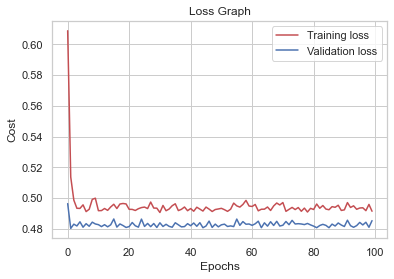

Best epoch: 2
Epoch 1/2
21/21 [==============================] - 1s 16ms/step - loss: 0.5787 - auc: 0.7094 - val_loss: 0.4961 - val_auc: 0.8112
Epoch 2/2
21/21 [==============================] - 0s 3ms/step - loss: 0.5184 - auc: 0.8178 - val_loss: 0.4832 - val_auc: 0.8081


In [40]:
remColsCombPred = DiabetesPredictor(df, 'remColsComb', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=removeCols, deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])
remColsCombPred.train_model()
aucRemColsComb = remColsCombPred.validate_model()

In [41]:
print('AUC: ' + str(aucRemColsComb))

AUC: 0.8076923076923077


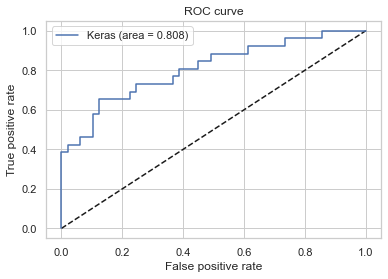

AUC 0.8076923076923077
Specificity: tf.Tensor(0.8979591818408996, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.5384615363905325, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7368421013850416, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.7857142843112245, shape=(), dtype=float64)


In [42]:
remColsCombPred.plot_roc()
remColsCombPred.get_metrics()

#### Sacando solo Pedigree

Trial 30 Complete [00h 00m 15s]
val_loss: 0.3578888277212779

Best val_loss So Far: 0.32846153775850934
Total elapsed time: 00h 05m 06s
INFO:tensorflow:Oracle triggered exit


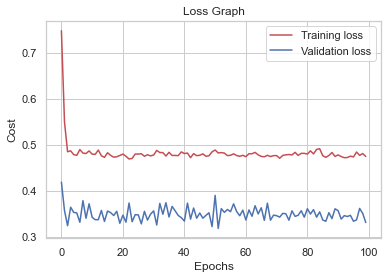

Best epoch: 52
Epoch 1/52
15/15 [==============================] - 1s 32ms/step - loss: 0.7247 - auc: 0.6742 - val_loss: 0.4432 - val_auc: 0.9000
Epoch 2/52
15/15 [==============================] - 0s 3ms/step - loss: 0.5621 - auc: 0.8138 - val_loss: 0.3439 - val_auc: 0.9067
Epoch 3/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4837 - auc: 0.8266 - val_loss: 0.3333 - val_auc: 0.9319
Epoch 4/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4789 - auc: 0.8238 - val_loss: 0.3828 - val_auc: 0.8941
Epoch 5/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4846 - auc: 0.8159 - val_loss: 0.3421 - val_auc: 0.9244
Epoch 6/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4722 - auc: 0.8280 - val_loss: 0.3458 - val_auc: 0.9176
Epoch 7/52
15/15 [==============================] - 0s 3ms/step - loss: 0.4755 - auc: 0.8241 - val_loss: 0.3468 - val_auc: 0.9176
Epoch 8/52
15/15 [==============================] - 0s 3ms/step - loss: 0.

In [43]:
remPedigreePred = DiabetesPredictor(df, 'remPedigreePred', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])
remPedigreePred.train_model()
aucRemPedigree = remPedigreePred.validate_model()

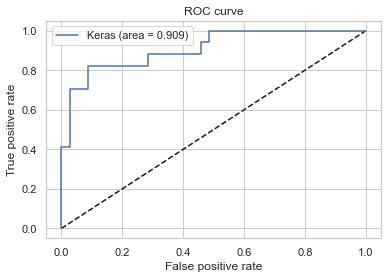

AUC 0.9092436974789916
Specificity: tf.Tensor(0.9142857116734694, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7058823487889273, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7999999946666667, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8648648625273923, shape=(), dtype=float64)


In [44]:
remPedigreePred.plot_roc()
remPedigreePred.get_metrics()

### Con PolynomialFeatures

INFO:tensorflow:Reloading Oracle from existing project saved_models\featPol\oracle.json
<ipython-input-22-3f8ae0ccd5ca>:60: RuntimeWarning: invalid value encountered in true_divide
  self.x = (self.x - x_mean)/x_std
INFO:tensorflow:Reloading Tuner from saved_models\featPol\tuner0.json
INFO:tensorflow:Oracle triggered exit


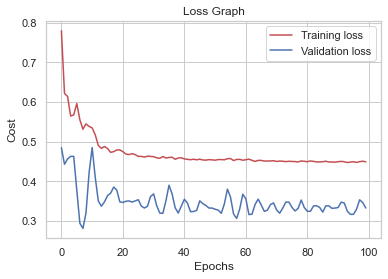

Best epoch: 8
Epoch 1/8
15/15 [==============================] - 1s 34ms/step - loss: 0.7759 - auc: 0.4782 - val_loss: 0.4819 - val_auc: 0.8941
Epoch 2/8
15/15 [==============================] - 0s 3ms/step - loss: 0.6027 - auc: 0.7855 - val_loss: 0.4485 - val_auc: 0.9042
Epoch 3/8
15/15 [==============================] - 0s 3ms/step - loss: 0.6270 - auc: 0.8159 - val_loss: 0.4803 - val_auc: 0.8899
Epoch 4/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5909 - auc: 0.8161 - val_loss: 0.4760 - val_auc: 0.8731
Epoch 5/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5736 - auc: 0.7941 - val_loss: 0.4539 - val_auc: 0.8605
Epoch 6/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5885 - auc: 0.7604 - val_loss: 0.3763 - val_auc: 0.8689
Epoch 7/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5598 - auc: 0.7797 - val_loss: 0.2954 - val_auc: 0.9160
Epoch 8/8
15/15 [==============================] - 0s 3ms/step - loss: 0.5507 - au

In [45]:
polyPred = DiabetesPredictor(df, 'featPol', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=2)
polyPred.train_model()
aucPolyPred = polyPred.validate_model()

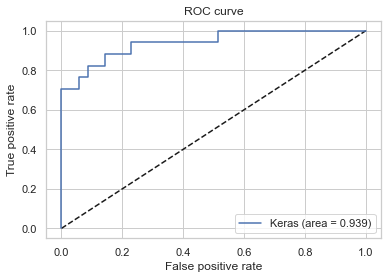

AUC 0.9394957983193277
Specificity: tf.Tensor(0.9428571401632653, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7647058778546713, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.866666660888889, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8918918894813732, shape=(), dtype=float64)


In [46]:
polyPred.plot_roc()
polyPred.get_metrics()

Trial 30 Complete [00h 00m 10s]
val_loss: 0.32692397634188336

Best val_loss So Far: 0.32231895128885907
Total elapsed time: 00h 04m 51s
INFO:tensorflow:Oracle triggered exit


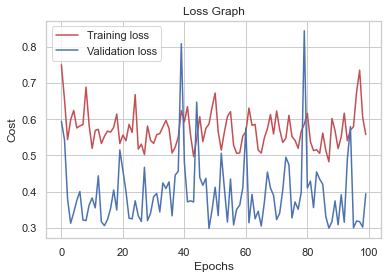

Best epoch: 49
Epoch 1/49
15/15 [==============================] - 1s 21ms/step - loss: 0.8023 - auc: 0.7383 - val_loss: 0.4148 - val_auc: 0.8832
Epoch 2/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5888 - auc: 0.7632 - val_loss: 0.3940 - val_auc: 0.8832
Epoch 3/49
15/15 [==============================] - 0s 2ms/step - loss: 0.6156 - auc: 0.7630 - val_loss: 0.4615 - val_auc: 0.8513
Epoch 4/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5520 - auc: 0.7966 - val_loss: 0.4789 - val_auc: 0.8445
Epoch 5/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5416 - auc: 0.7822 - val_loss: 0.4394 - val_auc: 0.8580
Epoch 6/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5129 - auc: 0.7992 - val_loss: 0.3970 - val_auc: 0.8941
Epoch 7/49
15/15 [==============================] - 0s 2ms/step - loss: 0.5495 - auc: 0.7897 - val_loss: 0.4950 - val_auc: 0.8370
Epoch 8/49
15/15 [==============================] - 0s 3ms/step - loss: 0.

In [47]:
polyPred1 = DiabetesPredictor(df, 'featPol1', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=1)
polyPred1.train_model()
aucPolyPred1 = polyPred1.validate_model()

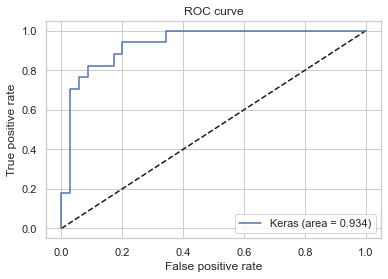

AUC 0.934453781512605
Specificity: tf.Tensor(0.9142857116734694, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7647058778546713, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.812499994921875, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.888888886419753, shape=(), dtype=float64)


In [48]:
polyPred1.plot_roc()
polyPred1.get_metrics()

INFO:tensorflow:Reloading Oracle from existing project saved_models\featPol3\oracle.json
<ipython-input-22-3f8ae0ccd5ca>:60: RuntimeWarning: invalid value encountered in true_divide
  self.x = (self.x - x_mean)/x_std
INFO:tensorflow:Reloading Tuner from saved_models\featPol3\tuner0.json
INFO:tensorflow:Oracle triggered exit


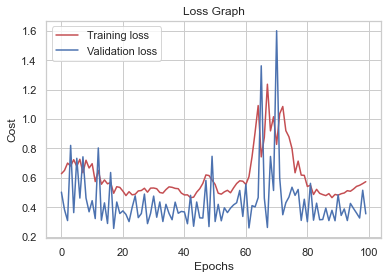

Best epoch: 18
Epoch 1/18
15/15 [==============================] - 1s 26ms/step - loss: 0.7119 - auc: 0.7194 - val_loss: 0.5722 - val_auc: 0.8655
Epoch 2/18
15/15 [==============================] - 0s 3ms/step - loss: 0.7586 - auc: 0.7146 - val_loss: 0.3556 - val_auc: 0.8807
Epoch 3/18
15/15 [==============================] - 0s 3ms/step - loss: 0.6957 - auc: 0.8023 - val_loss: 0.3890 - val_auc: 0.9168
Epoch 4/18
15/15 [==============================] - 0s 3ms/step - loss: 0.7113 - auc: 0.7776 - val_loss: 0.7393 - val_auc: 0.7513
Epoch 5/18
15/15 [==============================] - 0s 4ms/step - loss: 0.6335 - auc: 0.7846 - val_loss: 0.3212 - val_auc: 0.9235
Epoch 6/18
15/15 [==============================] - 0s 4ms/step - loss: 0.5682 - auc: 0.7963 - val_loss: 0.7093 - val_auc: 0.7277
Epoch 7/18
15/15 [==============================] - 0s 4ms/step - loss: 0.6161 - auc: 0.8003 - val_loss: 0.3627 - val_auc: 0.9353
Epoch 8/18
15/15 [==============================] - 0s 3ms/step - loss: 0.

In [49]:
polyPred3 = DiabetesPredictor(df, 'featPol3', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=2)
polyPred3.train_model()
aucPolyPred3 = polyPred3.validate_model()

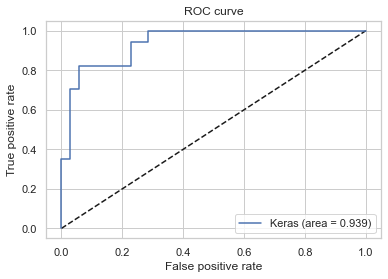

AUC 0.9394957983193277
Specificity: tf.Tensor(0.8857142831836734, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.8235294069204152, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7777777734567901, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.911764703200692, shape=(), dtype=float64)


In [50]:
polyPred3.plot_roc()
polyPred3.get_metrics()

INFO:tensorflow:Reloading Oracle from existing project saved_models\featPolBins\oracle.json
d:\Documentos\ITBA\4to año 2do cuatrimestre\Redes\TP2\env\lib\site-packages\sklearn\preprocessing\_discretization.py:187: UserWarning: Feature 0 is constant and will be replaced with 0.
  warnings.warn("Feature %d is constant and will be "
<ipython-input-22-3f8ae0ccd5ca>:60: RuntimeWarning: invalid value encountered in true_divide
  self.x = (self.x - x_mean)/x_std
INFO:tensorflow:Reloading Tuner from saved_models\featPolBins\tuner0.json
INFO:tensorflow:Oracle triggered exit


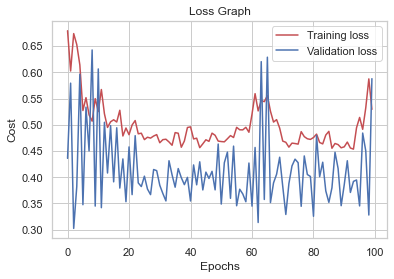

Best epoch: 3
Epoch 1/3
15/15 [==============================] - 1s 29ms/step - loss: 0.7496 - auc: 0.6835 - val_loss: 0.4654 - val_auc: 0.9059
Epoch 2/3
15/15 [==============================] - 0s 3ms/step - loss: 0.7456 - auc: 0.7545 - val_loss: 0.7016 - val_auc: 0.7849
Epoch 3/3
15/15 [==============================] - 0s 3ms/step - loss: 0.6936 - auc: 0.7690 - val_loss: 0.3277 - val_auc: 0.9193


In [51]:
polyBinsPred = DiabetesPredictor(df, 'featPolBins', deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=['DiabetesPedigreeFunction'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]], polyFeatDeg=2, binsDiscretizer=5)
polyBinsPred.train_model()
aucPolyBinsPred = polyBinsPred.validate_model()

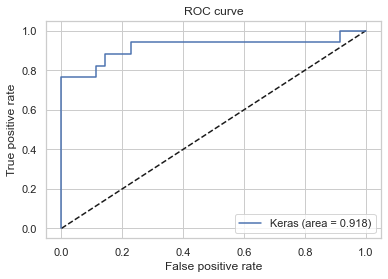

AUC 0.9176470588235295
Specificity: tf.Tensor(0.9428571401632653, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7647058778546713, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.866666660888889, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8918918894813732, shape=(), dtype=float64)


In [52]:
polyBinsPred.plot_roc()
polyBinsPred.get_metrics()